Nick Barkidjija
USC ID: 1398652770
Github username: nick-barkidjija

In [ ]:
import numpy as np
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


preprocessing and class encoding

In [ ]:


data_dir = '/content/drive/MyDrive/552-final-project/data/RealWaste'
processed_data_dir = '/content/drive/MyDrive/552-final-project/data/processed'

size = (224, 224)

if os.path.exists(processed_data_dir):
    shutil.rmtree(processed_data_dir)

for split in ['train', 'test']:
    os.makedirs(os.path.join(processed_data_dir, split), exist_ok=True)

for subclass in sorted(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, subclass)
    if not os.path.isdir(class_dir):
        continue

    image_files = sorted([
        f for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    if len(image_files) == 0:
        print(f"empty or invalid folder: {subclass}")
        continue

    train_dir = os.path.join(processed_data_dir, 'train', subclass)
    test_dir = os.path.join(processed_data_dir, 'test', subclass)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    num_train = int(len(image_files) * 0.8)
    train_files = image_files[:num_train]
    test_files = image_files[num_train:]

    for fname in tqdm(train_files, desc=f"Train - {subclass}"):
        img_path = os.path.join(class_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, size)
        save_path = os.path.join(train_dir, fname)
        cv2.imwrite(save_path, img_resized)

    for fname in tqdm(test_files, desc=f"Test - {subclass}"):
        img_path = os.path.join(class_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, size)
        save_path = os.path.join(test_dir, fname)
        cv2.imwrite(save_path, img_resized)

Test - 9-Vegetation: 100%|██████████| 88/88 [00:01<00:00, 54.13it/s]


In [ ]:

train_data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2
)

train_gen_implement = train_data_generator.flow_from_directory(
    '/content/drive/MyDrive/552-final-project/data/processed/train',
    target_size=size,
    batch_size=5,
    class_mode='categorical',
    subset='training'
)

val_gen_implement = train_data_generator.flow_from_directory(
    '/content/drive/MyDrive/552-final-project/data/processed/train',
    target_size=size,
    batch_size=5,
    class_mode='categorical',
    subset='validation'

)

test_data_generator = ImageDataGenerator()

test_gen_implement = test_data_generator.flow_from_directory(
    '/content/drive/MyDrive/552-final-project/data/processed/test',
    target_size=size,
    batch_size=5,
    class_mode='categorical',
    shuffle=False
)

Found 3061 images belonging to 9 classes.
Found 761 images belonging to 9 classes.
Found 960 images belonging to 9 classes.


In [ ]:
def build_transfer_model(base_model_fn, preprocess_input, input_shape=(224, 224, 3), num_classes=9):
    base_model = base_model_fn(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False # Freeze all base layers

    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(preprocess_input)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # 128 keeps model medium sized
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model




In [ ]:
model_dir = "/content/drive/MyDrive/552-final-project/models"

def training_evaluation(model, train_gen, val_gen, test_gen, model_name='model'):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=50)
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(model_dir, f"{model_name}_checkpoint.h5"),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    hist_results = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=65,
        batch_size=5,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist_results.history['accuracy'], label='Training Accuracy')
    plt.plot(hist_results.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(hist_results.history['loss'], label='Training Loss')
    plt.plot(hist_results.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    test_gen.reset()
    preds = model.predict(test_gen_implement)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    print(f"classification report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

    try:
        y_true_bin = np.eye(len(test_gen.class_indices))[y_true]
        auc_score = roc_auc_score(y_true_bin, preds, average='macro', multi_class='ovr')
        print(f"AUC Score (macro, OVR): {auc_score:.4f}")
    except:
        print("failed to compute AUC")

    return model


In [ ]:
model_architectures = {
    "ResNet50": {
        "base_fn": ResNet50,
        "preprocess_input": resnet_preprocess
    },
    "ResNet101": {
        "base_fn": ResNet101,
        "preprocess_input": resnet_preprocess
    },
    "VGG16": {
        "base_fn": VGG16,
        "preprocess_input": vgg_preprocess
    },
    "EfficientNetB0": {
        "base_fn": EfficientNetB0,
        "preprocess_input": effnet_preprocess
    }
}


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 99s 134ms/step - accuracy: 0.2729 - loss: 8.5085 - val_accuracy: 0.5375 - val_loss: 7.5059 - learning_rate: 1.0000e-04
Epoch 2/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 70s 113ms/step - accuracy: 0.5586 - loss: 7.3222 - val_accuracy: 0.5611 - val_loss: 7.1254 - learning_rate: 1.0000e-04
Epoch 3/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.6060 - loss: 6.9350 - val_accuracy: 0.5966 - val_loss: 6.7983 - learning_rate: 1.0000e-04
Epoch 4/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 68s 111ms/step - accuracy: 0.6604 - loss: 6.5120 - val_accuracy: 0.6137 - val_loss: 6.4293 - learning_rate: 1.0000e-04
Epoch 5/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 69s 113ms/step - accuracy: 0.6937 - loss: 6.1289 - val_accuracy: 0.6544 - val_loss: 6.0816 - learning_rate: 1.0000e-04
Epoch 6/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 68s 111ms/step - accuracy: 0.6906 - loss: 5.8068 - val_accuracy: 0.6675 - val_loss: 5.7195 - learning_rate: 1.0000e-04
Epoch 7/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 12

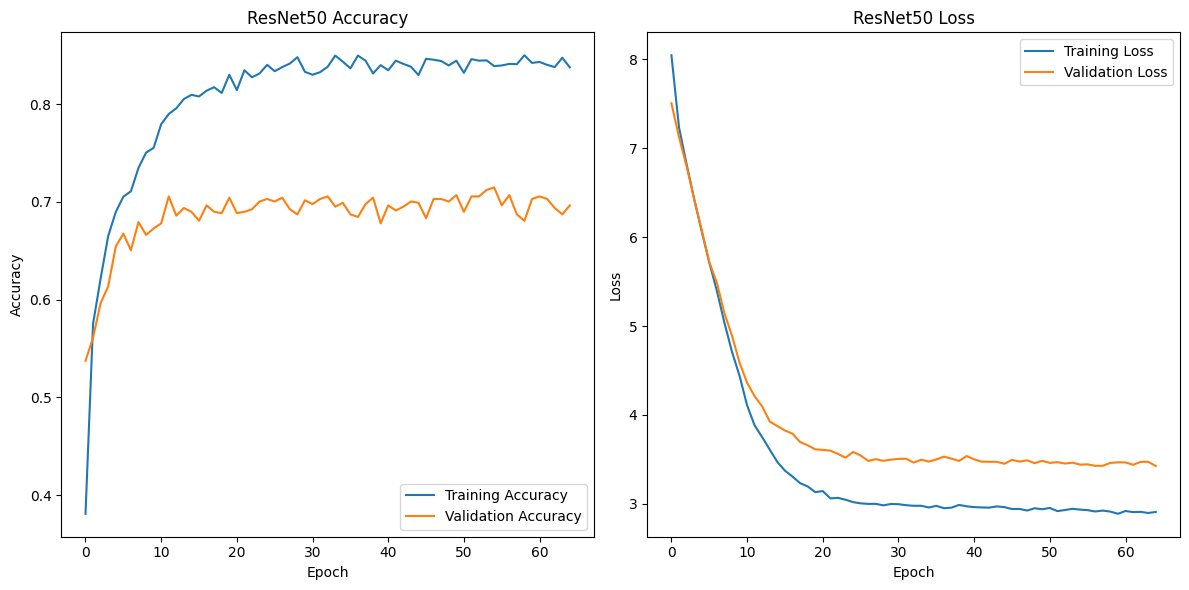

192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step


classification report for ResNet50:
                       precision    recall  f1-score   support

          1-Cardboard       0.73      0.84      0.78        93
      2-Food Organics       0.77      0.65      0.71        83
              3-Glass       0.75      0.77      0.76        84
              4-Metal       0.76      0.91      0.83       164
5-Miscellaneous Trash       0.67      0.44      0.53        99
              6-Paper       0.80      0.91      0.85       100
            7-Plastic       0.77      0.69      0.73       185
      8-Textile Trash       0.79      0.78      0.79        64
         9-Vegetation       0.88      0.91      0.89        88

             accuracy                           0.77       960
            macro avg       0.77      0.77      0.76       960
         weighted avg       0.77      0.77      0.76       960

AUC Score (macro, OVR): 0.9703
Training ResNet101...
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/65
613/613 ━━━━━━━━━━━━━━━━━

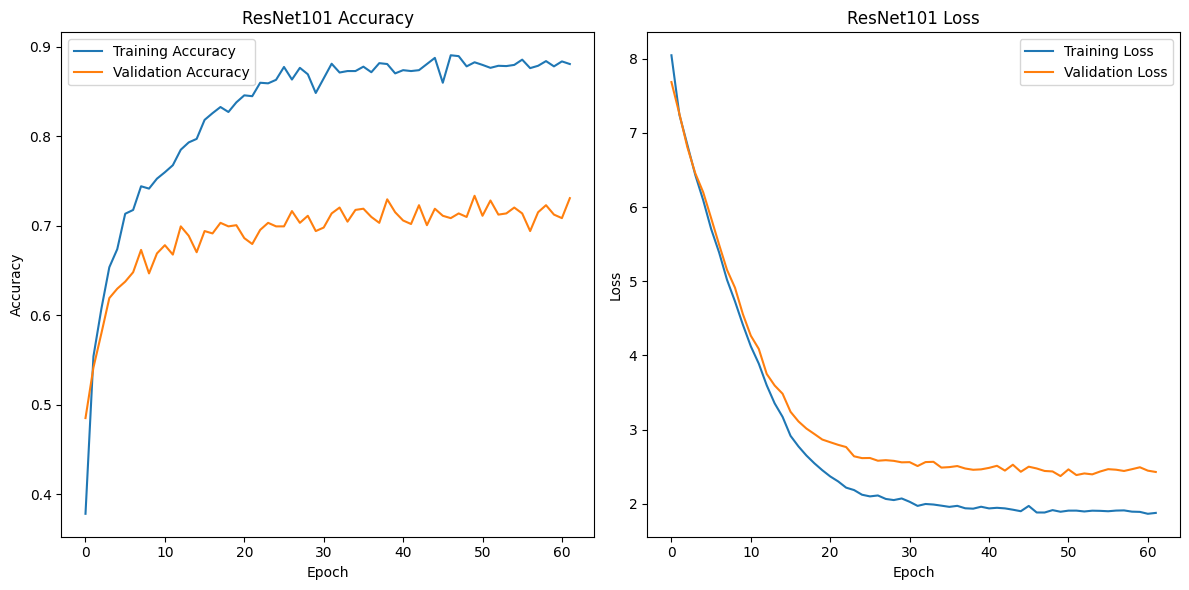

192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step


classification report for ResNet101:
                       precision    recall  f1-score   support

          1-Cardboard       0.65      0.90      0.76        93
      2-Food Organics       0.83      0.84      0.84        83
              3-Glass       0.83      0.62      0.71        84
              4-Metal       0.72      0.86      0.78       164
5-Miscellaneous Trash       0.68      0.48      0.56        99
              6-Paper       0.89      0.91      0.90       100
            7-Plastic       0.80      0.71      0.76       185
      8-Textile Trash       0.70      0.67      0.69        64
         9-Vegetation       0.89      0.91      0.90        88

             accuracy                           0.77       960
            macro avg       0.78      0.77      0.77       960
         weighted avg       0.78      0.77      0.77       960

AUC Score (macro, OVR): 0.9703
Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 8

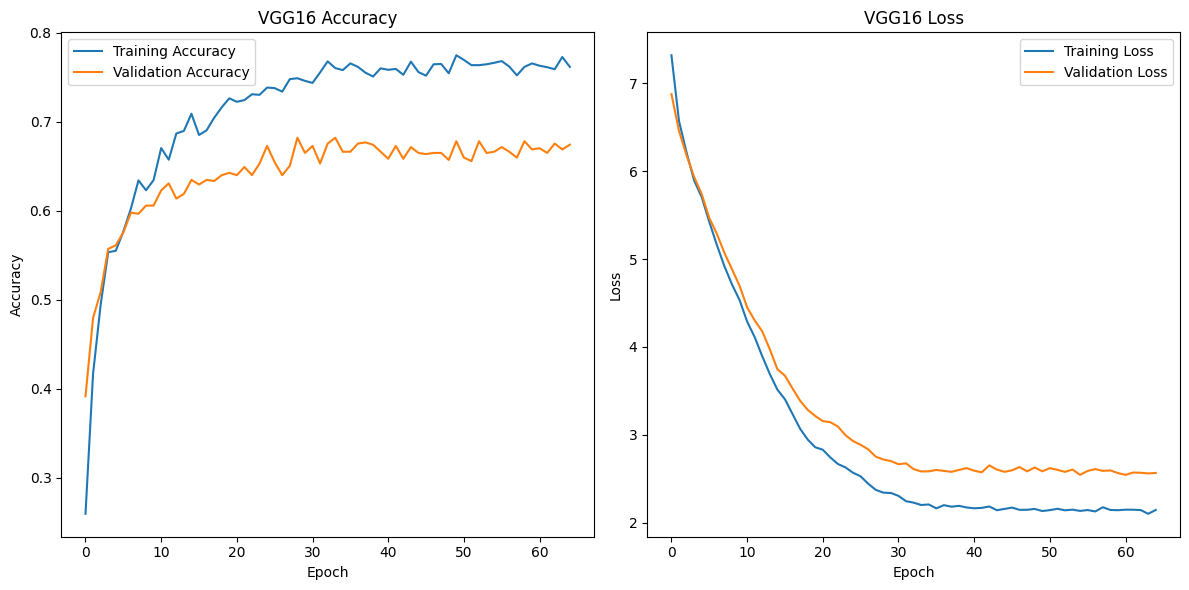

192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
classification report for VGG16:


                       precision    recall  f1-score   support

          1-Cardboard       0.82      0.80      0.81        93
      2-Food Organics       0.85      0.66      0.74        83
              3-Glass       0.71      0.60      0.65        84
              4-Metal       0.70      0.85      0.77       164
5-Miscellaneous Trash       0.56      0.41      0.48        99
              6-Paper       0.83      0.87      0.85       100
            7-Plastic       0.70      0.75      0.72       185
      8-Textile Trash       0.70      0.70      0.70        64
         9-Vegetation       0.84      0.91      0.87        88

             accuracy                           0.74       960
            macro avg       0.75      0.73      0.73       960
         weighted avg       0.74      0.74      0.73       960

AUC Score (macro, OVR): 0.9576
Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/65
613/613 ━━━━━━━━━━━━━━━━━━━━ 134s 178ms/step - accuracy: 0

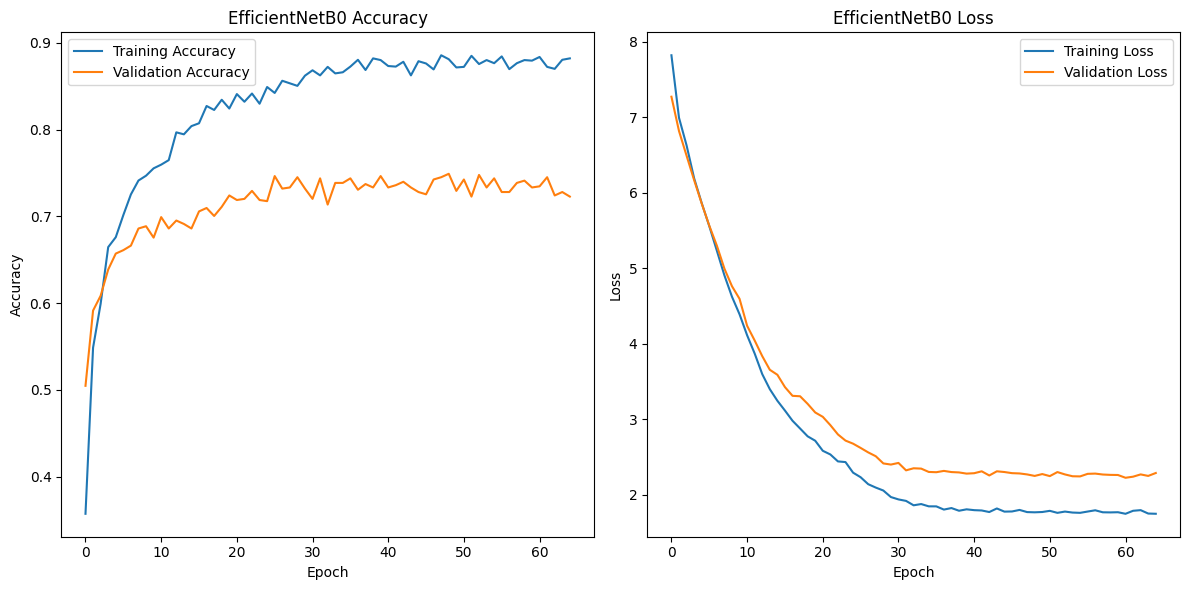

192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step


classification report for EfficientNetB0:
                       precision    recall  f1-score   support

          1-Cardboard       0.77      0.84      0.80        93
      2-Food Organics       0.80      0.66      0.72        83
              3-Glass       0.79      0.82      0.81        84
              4-Metal       0.84      0.87      0.85       164
5-Miscellaneous Trash       0.66      0.58      0.61        99
              6-Paper       0.86      0.95      0.90       100
            7-Plastic       0.80      0.80      0.80       185
      8-Textile Trash       0.72      0.73      0.73        64
         9-Vegetation       0.93      0.91      0.92        88

             accuracy                           0.80       960
            macro avg       0.80      0.80      0.80       960
         weighted avg       0.80      0.80      0.80       960

AUC Score (macro, OVR): 0.9751


In [ ]:

for model_name, config in model_architectures.items():
    print(f"Training {model_name}...")
    model = build_transfer_model(base_model_fn=config["base_fn"], preprocess_input=config["preprocess_input"], num_classes=train_gen_implement.num_classes)
    model = training_evaluation(model, train_gen_implement, val_gen_implement, test_gen_implement, model_name)

    model.save(f"/content/drive/MyDrive/552-final-project/models/{model_name}_model.h5")


Overall, I think the best performing model was the EfficientNetB0. In all metrics, it had heigher weighted averages and macro averages, combined with a higher accuracy score and the highest AUC.